# Generalizing the Hamiltonian Monte-Carlo sampler.

## The objective here is to apply the Hamiltonian Monte-Carlo to a more realistic problem.

`Arthur Loureiro - UCL PAD Feb/2019`

> Based on http://people.duke.edu/~ccc14/sta-663-2018/notebooks/S10E_HMC.html

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as plt
from functools import partial
import seaborn as sns
import scipy.linalg as la
import matplotlib as mpl

mpl.rcParams.update({'font.size': 16})

np.random.seed(123)

## We start by creating some synthetic data:

(based on the [emcee tutorial](https://emcee.readthedocs.io/en/latest/tutorials/line/))

In [120]:
# the truth cell:
a_true = -0.8
b_true = 2.39
f_true = 0.50

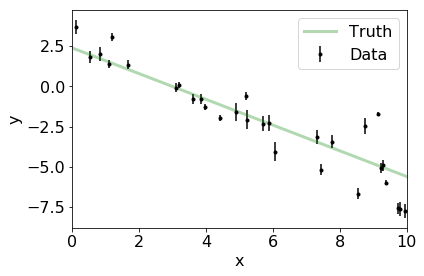

In [121]:
# Generate some synthetic data from the model.
N = 30
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = a_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
#y += np.abs(y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0,label="Data")
x0 = np.linspace(0, 10, 500)
plt.plot(x0, a_true*x0+b_true, "g", alpha=0.3, lw=3, label="Truth")
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc=0)

# Likelihood:
The log-Likelihood can be defined in this case as:

#### $\psi(y|d,\sigma,a,b,f) = \ln Pr(y|d,\sigma,a,b,f) = -\frac{1}{2}\sum_i \left[ \frac{(y_i - ax_i -b)^2}{\Sigma_i^2} + \ln(2\pi\Sigma_i^2)\right]$

where, $\Sigma_i^2 \equiv \sigma_i^2 + f^2(ax_i+b)^2$ -- meaning that the variance can be considered to have been underestimated by some fractional amount, $f$.

In [122]:
def log_likelihood(theta, x, y, yerr):
    a, b = theta
    model = a * x + b
    sigma2 = yerr**2 #+ model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2)# + np.log(sigma2))

# Priors:

For simplicity, let us consider flat, uniform priors:

$\Pi(a) = \begin{cases} 1 , & if\, -5 < a < 1/2 \\ 0,& otherwise\end{cases}$

$\Pi(b) = \begin{cases} 1 , & if\, 0 < b < 10 \\ 0,& otherwise\end{cases}$

$\Pi(f) = \begin{cases} 1 , & if\, -10 < \log(f) < 1 \\ 0,& otherwise\end{cases}$

In [123]:
def log_prior(theta):
    a, b = theta
    if -5.0 < a < 0.5 and 0.0 < b < 10.0:# and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

## Now, we define the potencial to be the negative log-posterior distribution:

In [124]:
def neglog_post(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return -(lp + log_likelihood(theta, x, y, yerr))

In [125]:
def dH(theta0, p0, theta, p, x, y, yerr):
    """
    Hamiltonian of the system
    """
    H0 = neglog_post(theta0, x, y, yerr) + (p0 @ p0)/2
    H1 = neglog_post(theta, x, y, yerr) + (p @ p)/2
    return (H0 - H1)

In [185]:
# using leap-frog to evolve the system
def leapfrog(A, x, p, h, N):
    """Leapfrog finite difference scheme."""
    p = p - h/2 * A @ x
    for i in range(N-1):
        x = x + h * p
        p = p - h * A @ x

    x = x + h * p
    p = p - h/2 * A @ x

    return x, p

In [190]:
# number of samples:
niter = 1500

# This is a free parameter that controls the acceptance ratio:
h = 0.01

# Number of steps in the leap-frog integration:
N = 100

# step size = sigma^-1:
#tau = np.matrix([[np.sum(-x**2/yerr),0],[0,np.sum(-1/yerr)]])#,[0,1,0,0], [1,0,0,0]])


# inicializing the trajectories:
orbit = np.zeros((niter+1, 2))

# inicial position:
theta = np.array([-1,3])
orbit[0] = theta

In [191]:
for k in range(niter):
    # the inicial momenta can be sampled from a normal distr:
    p0 = np.random.normal(0,1,2)
    
    
    theta, p = leapfrog(tau, theta, p0, h, N)

    # accept-reject
    theta0 = orbit[k]
    a = np.exp(dH(theta0, p0, theta, -p, x, y, yerr))
    r = np.random.rand()

    if r < a:
        orbit[k+1] = theta
        #print('accepted!')
    else:
        orbit[k+1] = theta0
        #print('rejected')
        
# and plot:
sns.kdeplot(orbit[:, 0], orbit[:, 1],shade=True)
#sns.kdeplot(y[:,0], ys[:,1])
plt.plot(orbit[:,0], orbit[:,1], alpha=0.2)
plt.scatter(orbit[:1,0], orbit[:1,1],  c='red', s=30)
plt.scatter(orbit[1:,0], orbit[1:,1],  c=np.arange(niter)[::-1], cmap='Reds')
#plt.axis([-5.5,1.5,0.1,10])

ValueError: shapes (2,2) and (1,2) not aligned: 2 (dim 1) != 1 (dim 0)

In [50]:
np.shape(yerr)

(50,)

In [129]:
orbit

array([[-1.        ,  3.        ],
       [-0.86341373,  2.81247586],
       [-0.86341373,  2.81247586],
       ...,
       [-0.50412607, -0.08350382],
       [-0.50412607, -0.08350382],
       [-0.50412607, -0.08350382]])